In [ ]:
from google.colab import files
!pip install -q kaggle

In [ ]:
#upload api key
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle/
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d lokkagle/movie-genre-data
! unzip movie-genre-data.zip

 53% 5.00M/9.46M [00:00<00:00, 9.31MB/s]
100% 9.46M/9.46M [00:00<00:00, 16.0MB/s]
Archive:  movie-genre-data.zip
  inflating: kaggle_movie_train.csv  


In [ ]:
#all import
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import string
import nltk
import itertools
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

In [31]:
df = pd.read_csv("kaggle_movie_train.csv")
df

,id,text,genre
0,0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
1,2,"t, summa cum laude and all. And I'm about to l...",comedy
2,3,"up Come, I have a surprise.... She takes him ...",drama
3,4,ded by the two detectives. INT. JEFF'S APARTME...,thriller
4,5,"nd dismounts, just as the other children reach...",drama
...,...,...,...
22574,28161,n in the world to decide what I'm going to do ...,drama
22575,28162,shards. BOJO LAZ! Laz pushes Deke back through...,drama
22576,28163,"OTTIE You've got a thing about Ernie's, haven'...",thriller
22577,28165,....with marked skill and dexterity . LANA wry...,action


In [32]:
#check genre yang ada
df['genre'].value_counts()

drama        8873
thriller     6824
comedy       2941
action       2392
sci-fi        613
horror        456
other         270
adventure     147
romance        63
Name: genre, dtype: int64

In [33]:
#drop id
df = df.drop(columns=['id'])
#ambol 3 genre saja comedy,action, other(sci_fi+horror+adventure,romance)
df['genre'].replace({"sci-fi":"other",
                     "horror":"other",
                     "adventure":"other",
                     "romance":"other"}, inplace=True)
#hanya mengambil 3 genre
df = df[~df['genre'].isin(['drama','thriller'])]
df

,text,genre
1,"t, summa cum laude and all. And I'm about to l...",comedy
9,e reels as the world spins. Sweat pours off hi...,action
20,I say he's a man who'll go far. Some people s...,comedy
25,you find out where the bachelor party is? COLE...,comedy
29,ibly horrendous public break up on the quad. A...,comedy
...,...,...
22566,"BUT THEN YOU KNEW THAT. Inhaling some bliss, S...",action
22569,d Cricket running down road. DISSOLVE TO 53. E...,other
22573,"Well hello, officer. WYDELL holding up his ba...",other
22577,....with marked skill and dexterity . LANA wry...,action


In [34]:
#check value masing masing genre
df['genre'].value_counts()

comedy    2941
action    2392
other     1549
Name: genre, dtype: int64

DATA CLEAN

In [35]:
def case_fold(text):
  #remove number
  text = re.sub(r"\d+", "", str(text))
  #Menghapus HTTP yang tidak selesai
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  #menghapus kata-kata ganda
  text = re.sub(r"\b(\w+)(?:\W\1\b)+", r"\1", text, flags=re.IGNORECASE)
  # remove tab, new line, ans back slice
  text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
  # remove non ASCII (emoticon, chinese word, .etc)
  text = text.encode('ascii', 'replace').decode('ascii')
  # remove mention, link, hashtag
  text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
  # remove incomplete URL
  text.replace("http://", " ").replace("https://", " ")
  #remove punctuation
  text = text.translate(str.maketrans("","",string.punctuation))
  #remove whitestrip
  text = text.strip()
  #remove multiple whitespace into single whitespace
  text = re.sub('\s+',' ',text)
  #remove single char
  text = re.sub(r"\b[a-zA-Z]\b", "", text)
  #remove url
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  text = url_pattern.sub(r'', text)
  #duplicate alphabet
  text = ''.join(alp for alp, _ in itertools.groupby(text))
  #membuat semua komentar menjadi huruf kecil 
  text = text.lower()
  return text
df['Case_Fold'] = df['text'].apply(case_fold)

In [36]:
#stopwords english
nltk.download('stopwords')
stop = stopwords.words('english')
df['Stopwords'] = df['Case_Fold'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,genre,Case_Fold,Stopwords
1,"t, summa cum laude and all. And I'm about to l...",comedy,suma cum laude and al and im about to launch ...,suma cum laude al im launch brand new magazine...
9,e reels as the world spins. Sweat pours off hi...,action,rels as the world spins sweat pours of him as...,rels world spins sweat pours presure builds in...
20,I say he's a man who'll go far. Some people s...,comedy,say hes man whol go far some people say hes g...,say hes man whol go far people say hes gone fa...
25,you find out where the bachelor party is? COLE...,comedy,you find out where the bachelor party is cole ...,find bachelor party cole yes mr fine hows ever...
29,ibly horrendous public break up on the quad. A...,comedy,ibly horendous public break up on the quad aga...,ibly horendous public break quad cameron wel t...
...,...,...,...,...
22566,"BUT THEN YOU KNEW THAT. Inhaling some bliss, S...",action,but then you knew that inhaling some blis seli...,knew inhaling blis selina leans back wal next ...
22569,d Cricket running down road. DISSOLVE TO 53. E...,other,cricket runing down road disolve to ext back ...,cricket runing road disolve ext back porch wil...
22573,"Well hello, officer. WYDELL holding up his ba...",other,wel helo oficer wydel holding up his badge exc...,wel helo oficer wydel holding badge excuse im ...
22577,....with marked skill and dexterity . LANA wry...,action,with marked skil and dexterity lana wryly youd...,marked skil dexterity lana wryly youd surprise...


In [37]:
#lema
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df['Lemma']= df['Stopwords'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()  ]))
df

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,genre,Case_Fold,Stopwords,Lemma
1,"t, summa cum laude and all. And I'm about to l...",comedy,suma cum laude and al and im about to launch ...,suma cum laude al im launch brand new magazine...,suma cum laude al im launch brand new magazine...
9,e reels as the world spins. Sweat pours off hi...,action,rels as the world spins sweat pours of him as...,rels world spins sweat pours presure builds in...,rels world spin sweat pours presure build insi...
20,I say he's a man who'll go far. Some people s...,comedy,say hes man whol go far some people say hes g...,say hes man whol go far people say hes gone fa...,say he man whol go far people say he gone far ...
25,you find out where the bachelor party is? COLE...,comedy,you find out where the bachelor party is cole ...,find bachelor party cole yes mr fine hows ever...,find bachelor party cole yes mr fine hows ever...
29,ibly horrendous public break up on the quad. A...,comedy,ibly horendous public break up on the quad aga...,ibly horendous public break quad cameron wel t...,ibly horendous public break quad cameron wel t...
...,...,...,...,...,...
22566,"BUT THEN YOU KNEW THAT. Inhaling some bliss, S...",action,but then you knew that inhaling some blis seli...,knew inhaling blis selina leans back wal next ...,knew inhaling blis selina lean back wal next t...
22569,d Cricket running down road. DISSOLVE TO 53. E...,other,cricket runing down road disolve to ext back ...,cricket runing road disolve ext back porch wil...,cricket runing road disolve ext back porch wil...
22573,"Well hello, officer. WYDELL holding up his ba...",other,wel helo oficer wydel holding up his badge exc...,wel helo oficer wydel holding badge excuse im ...,wel helo oficer wydel holding badge excuse im ...
22577,....with marked skill and dexterity . LANA wry...,action,with marked skil and dexterity lana wryly youd...,marked skil dexterity lana wryly youd surprise...,marked skil dexterity lana wryly youd surprise...


In [38]:
#membuat dataframe hasil data clean
df = df.drop(columns=['text','Case_Fold','Stopwords'])
df = df.reindex(['Lemma','genre'], axis=1)
df = df.rename(columns={"Lemma": "text"})
df

,text,genre
1,suma cum laude al im launch brand new magazine...,comedy
9,rels world spin sweat pours presure build insi...,action
20,say he man whol go far people say he gone far ...,comedy
25,find bachelor party cole yes mr fine hows ever...,comedy
29,ibly horendous public break quad cameron wel t...,comedy
...,...,...
22566,knew inhaling blis selina lean back wal next t...,action
22569,cricket runing road disolve ext back porch wil...,other
22573,wel helo oficer wydel holding badge excuse im ...,other
22577,marked skil dexterity lana wryly youd surprise...,action


ONE HOT ENCODING


In [39]:
genre = pd.get_dummies(df.genre)
df_new = pd.concat([df,genre],axis=1)
df_new = df_new.drop(columns=['genre'])
df_new

,text,action,comedy,other
1,suma cum laude al im launch brand new magazine...,0,1,0
9,rels world spin sweat pours presure build insi...,1,0,0
20,say he man whol go far people say he gone far ...,0,1,0
25,find bachelor party cole yes mr fine hows ever...,0,1,0
29,ibly horendous public break quad cameron wel t...,0,1,0
...,...,...,...,...
22566,knew inhaling blis selina lean back wal next t...,1,0,0
22569,cricket runing road disolve ext back porch wil...,0,0,1
22573,wel helo oficer wydel holding badge excuse im ...,0,0,1
22577,marked skil dexterity lana wryly youd surprise...,1,0,0


In [40]:
text = df_new['text'].astype(str)
label = df_new[['action','comedy','other']].values

In [41]:
#split data
X_train,X_test,y_train,y_test = train_test_split(text,label, test_size=0.2)

In [64]:
#TOKENIZER
tokenizer = Tokenizer(num_words=8000, oov_token='x')
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

sekuens_train = tokenizer.texts_to_sequences(X_train)
sekuens_test = tokenizer.texts_to_sequences(X_test)

padded_train = pad_sequences(sekuens_train)
padded_test = pad_sequences(sekuens_test)

In [65]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=8000, output_dim=16),
                             tf.keras.layers.LSTM(64),

                             tf.keras.layers.Dense(128,activation='relu'),
                             tf.keras.layers.Dense(64,activation='relu'),
                             tf.keras.layers.Dense(32,activation='relu'),
                             
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(3, activation='softmax')
])

In [66]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [67]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90 and logs.get('val_accuracy')>0.90 ):
      print("\nAkurasi telah mencapai >85%!")
      self.model.stop_training = True
callbacks = myCallback()

In [68]:
history = model.fit(padded_train, 
                    y_train, 
                    epochs=30, 
                    callbacks=[callbacks],
                    batch_size=64,
                    validation_data=(padded_test, y_test), 
                    verbose=2)

Epoch 1/30
87/87 - 11s - loss: 1.0529 - accuracy: 0.4200 - val_loss: 0.8309 - val_accuracy: 0.5839
Epoch 2/30
87/87 - 9s - loss: 0.6301 - accuracy: 0.6797 - val_loss: 0.4682 - val_accuracy: 0.7778
Epoch 3/30
87/87 - 8s - loss: 0.3762 - accuracy: 0.8427 - val_loss: 0.4719 - val_accuracy: 0.8054
Epoch 4/30
87/87 - 9s - loss: 0.2053 - accuracy: 0.9286 - val_loss: 0.4926 - val_accuracy: 0.8293
Epoch 5/30
87/87 - 9s - loss: 0.0995 - accuracy: 0.9704 - val_loss: 1.1265 - val_accuracy: 0.7712
Epoch 6/30
87/87 - 9s - loss: 0.2659 - accuracy: 0.9144 - val_loss: 0.5138 - val_accuracy: 0.8548
Epoch 7/30
87/87 - 8s - loss: 0.0657 - accuracy: 0.9855 - val_loss: 0.3927 - val_accuracy: 0.9034

Akurasi telah mencapai >85%!


In [69]:
model.evaluate(padded_test,y_test)

44/44 [==============================] - 1s 16ms/step - loss: 0.3927 - accuracy: 0.9034


[0.3927255868911743, 0.9034132361412048]

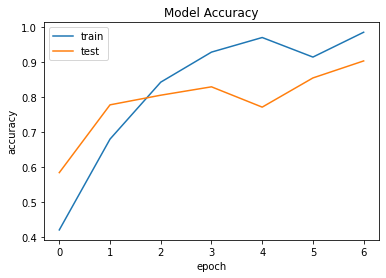

In [70]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

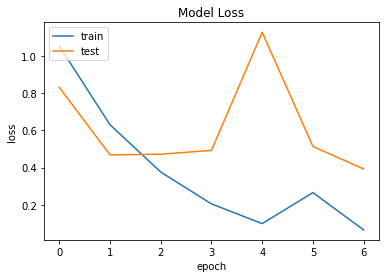

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()